# Setting up Spark Environment

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("Social Commerce").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1000m").\
        config("spark.executor.cores", "2").\
        config("spark.cores.max", "6").\
        getOrCreate()



23/05/22 08:32:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Install necessary packages
#!pip install pyspark==3.2.0

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Create SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()

## Libraries and Modules Installation

In [3]:
#Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import reduce

## Data Collection

In [4]:
#! apt-get update
#! apt-get install wget -y

In [5]:
#! wget https://storage.googleapis.com/22may2023/testfunnel.csv
#! wget https://storage.googleapis.com/aekanunlab/funneldata.zip

In [6]:
#! apt-get update
#! apt-get install unzip -y

In [7]:
#! unzip funneldata.zip

In [8]:
#! head -3 testfunnel.csv
! head -3 000000000000

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [9]:
#! wc -l testfunnel.csv
! wc -l 000000000000

917815 000000000000


In [10]:
raw_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('./000000000000')

# 1. Business Understanding

**ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)**

In [11]:
business_requiredCol_list = [] ### ให้รู้ว่านี่คือรายชื่อ col. ที่ ignore ไม่ได้ และในท้ายที่สุดต้องยอม clean null ด้วย .dropna() บน col. เหล่านี้
highDispersion = []
highScale = []
ignoredCols = []
featureTrainingCols = []

In [12]:
business_requiredCol_list = [x for x in raw_df.columns]

In [13]:
customerBehaviorCol_list = [x for x in raw_df.columns \
         if ((x != 'sourceKeyword')&(x != 'fullVisitorId')&(x != 'isVideoAd')&(x != 'date')\
             &(x != 'isTrueDirect')&(x != 'hitHour')&(x != 'hitMin')&(x != 'isClick')\
             &(x != 'productListName')&(x != 'isImpression')&(x != 'sessionQualityDim')&(x != 'timeOnScreen')\
             &(x != 'hitReferer')&(x != 'medium')&(x != 'hitType'))]

In [14]:
customerBehaviorCol_list

['source',
 'visitId',
 'newVisits',
 'hitAction_type',
 'hitNumber',
 'timeMicroSec',
 'v2ProductName',
 'timeOnSite',
 'totalTransactionRevenue']

# 2. Data Understanding

### 2.1 Previewing Data

In [15]:
raw_df.count()

917814

In [16]:
len(raw_df.columns)

24

In [17]:
raw_df.sample(0.00001).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
source,google,youtube.com,(direct),(direct),google,google,(direct),dealspotr.com,dfa,(direct),(direct),(direct),(direct),youtube.com
isTrueDirect,None,None,True,True,None,True,None,True,None,None,None,True,None,None
sourceKeyword,(not provided),None,None,None,(not provided),(not provided),None,None,None,None,None,None,None,None
medium,organic,referral,(none),(none),organic,organic,(none),referral,cpm,(none),(none),(none),(none),referral
isVideoAd,None,None,None,None,None,None,False,None,None,None,None,None,None,None
fullVisitorId,5070056991075293117,5074586247101127421,5130056554393615767,5315382266855883329,5321946631101127690,5327166854580374902,5334084551812671759,5340054383477452565,534307854432894042,5361740147764280334,5401221648631268019,5427948671398421463,5442111225181173959,5484991115522820610
visitId,1493062719,1479355447,1479838705,1471884865,1471559694,1472844906,1481743393,1492100868,1501358403,1471930640,1500173136,1475066022,1486496624,1486249397
date,20170424,20161116,20161122,20160822,20160818,20160902,20161214,20170413,20170729,20160822,20170715,20160928,20170207,20170204
newVisits,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0
hitReferer,None,https://www.youtube.com/yt/about/,None,None,None,None,None,None,http://tpc.googlesyndication.com/safeframe/1-0...,None,None,None,None,None


In [18]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransac

### 2.2 Basic Stat เพื่อพิจารณาในระดับเบื้องต้นเกี่ยวกับ Null, Abnormal ซึ่งดูจาก Value Ranges 



In [19]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,917814,None,None,(direct),youtube.com
sourceKeyword,322031,None,None,(Remarketing/Content targeting),yyoutubr
medium,917814,None,None,(none),referral
fullVisitorId,917814,4.7679506549928141E18,1.42707561410277837E18,514359656957582,5487531102128447544
visitId,917814,1.4828991660307045E9,9692290.975135243,1470037326,1501656575
date,917814,2.0165139267192483E7,4699.035428253378,20160801,20170801
newVisits,647359,1.0,0.0,1,1
hitReferer,119959,None,None,http://googleads.g.doubleclick.net/pagead/ads?...,https://youtube.com/yt/about/copyright/
hitType,917814,None,None,EVENT,PAGE


In [20]:
### ทำให้เห็นว่า timeOnScreen, hitReferer แม้ว่า Business จะ require แต่ก็ไม่มีประโยชน์จะเก็บไว้ หรือบาง col อาจซับซ้อนเกินกว่าจะนำไปวิเคราะห์ใช้งาน

ignoredCols = ['timeOnScreen','hitReferer','v2ProductName']

### 2.3 แบ่งแยก Numeric Columns และ Non Numeric Columns

In [21]:
from pyspark.sql.types import IntegerType, FloatType, LongType, StringType

numeric_columns = []
non_numeric_columns = []

for col_name in raw_df.columns:
    # Check if the column type is numeric
    if isinstance(raw_df.schema[col_name].dataType, (IntegerType, FloatType, LongType)):
        numeric_columns.append(col_name)
    else:
        non_numeric_columns.append(col_name)

print(f"Numeric columns: {numeric_columns}")
print(f"Non-numeric columns: {non_numeric_columns}")


Numeric columns: ['fullVisitorId', 'visitId', 'date', 'newVisits', 'hitAction_type', 'hitNumber', 'hitHour', 'hitMin', 'timeMicroSec', 'sessionQualityDim', 'timeOnSite', 'totalTransactionRevenue']
Non-numeric columns: ['source', 'isTrueDirect', 'sourceKeyword', 'medium', 'isVideoAd', 'hitReferer', 'hitType', 'v2ProductName', 'productListName', 'isClick', 'isImpression', 'timeOnScreen']


In [22]:
numeric_columns

['fullVisitorId',
 'visitId',
 'date',
 'newVisits',
 'hitAction_type',
 'hitNumber',
 'hitHour',
 'hitMin',
 'timeMicroSec',
 'sessionQualityDim',
 'timeOnSite',
 'totalTransactionRevenue']

In [23]:
non_numeric_columns

['source',
 'isTrueDirect',
 'sourceKeyword',
 'medium',
 'isVideoAd',
 'hitReferer',
 'hitType',
 'v2ProductName',
 'productListName',
 'isClick',
 'isImpression',
 'timeOnScreen']

### 2.4 Null Profiling

In [24]:
### ละทิ้ง column แบบ Boolean จาก non numeric col. เพราะว่า หากไม่ละทิ้ง จะเกิด error ต้องเช็คค่าว่างด้วย isnan()

non_numeric_columns.remove('isTrueDirect')
non_numeric_columns.remove('isVideoAd')
non_numeric_columns.remove('isClick')
non_numeric_columns.remove('isImpression')

In [25]:
from pyspark.sql.functions import count, when, isnan, col
# Check for null values for non numeric column
raw_df.select(non_numeric_columns).select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                           for c in raw_df.select(non_numeric_columns).columns]).toPandas().transpose()




,0
source,0
sourceKeyword,595783
medium,0
hitReferer,797855
hitType,0
v2ProductName,0
productListName,0
timeOnScreen,917814


In [26]:
from pyspark.sql.functions import count, when, isnan, col
# Check for null values for numeric column
raw_df.select(numeric_columns).select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                       for c in raw_df.select(numeric_columns).columns]).toPandas().transpose()

,0
fullVisitorId,0
visitId,0
date,0
newVisits,270455
hitAction_type,0
hitNumber,0
hitHour,0
hitMin,0
timeMicroSec,0
sessionQualityDim,856032


In [27]:
for a in business_requiredCol_list:
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+------+
|              source| count|
+--------------------+------+
|            (direct)|502654|
|              google|320612|
|         youtube.com| 34750|
|            Partners|  9949|
|                 dfa|  8696|
|analytics.google.com|  6144|
|          google.com|  4537|
|    sites.google.com|  3866|
|siliconvalley.abo...|  3399|
|      m.facebook.com|  2283|
|        facebook.com|  2073|
|          reddit.com|  1978|
|     mail.google.com|  1833|
|                bing|  1543|
|           qiita.com|  1496|
|               yahoo|  1441|
|           quora.com|  1252|
|                t.co|   996|
|   groups.google.com|   950|
|      l.facebook.com|   517|
+--------------------+------+
only showing top 20 rows



+------------+------+
|isTrueDirect| count|
+------------+------+
|        null|580491|
|        true|337323|
+------------+------+



+--------------------+------+
|       sourceKeyword| count|
+--------------------+------+
|                null|595783|
|      (not provided)|296422|
|    6qEhsCssdK0z36ri| 12471|
|  Google Merchandise|  2529|
|    1hZbAqLCbjwfgOH7|  2273|
|google merchandis...|  2061|
|    category_l1==166|   457|
|(Remarketing/Cont...|   373|
|    1X4Me6ZKNV0zg-jV|   330|
|googlemerchandise...|   323|
|             youtube|   207|
|+google +merchand...|   201|
|        google merch|   198|
|         google stor|   171|
|       youtube merch|   169|
|+Google +Merchandise|   164|
|Google Merchandis...|   164|
|      +google +store|   162|
|             Youtube|   140|
|        google store|   121|
+--------------------+------+
only showing top 20 rows



+---------+------+
|   medium| count|
+---------+------+
|   (none)|502654|
|  organic|302345|
| referral| 72078|
|      cpc| 21580|
|affiliate|  9949|
|      cpm|  9136|
|(not set)|    72|
+---------+------+



+---------+------+
|isVideoAd| count|
+---------+------+
|     null|885422|
|    false| 32392|
+---------+------+



+-------------------+-----+
|      fullVisitorId|count|
+-------------------+-----+
|5456301402188625337| 3416|
|5208937953046059083| 2377|
|5399906287295745418| 2338|
|5310912563447452038| 1792|
|5370310992308515600| 1777|
|5143600689169444167| 1651|
|5217792392522047587| 1605|
|4998444590527389280| 1550|
|5479405825116961439| 1482|
|5174129705003851738| 1472|
|5341271361784611942| 1443|
|5305785224618680102| 1413|
|5423659711610895780| 1267|
|5002959687839673544| 1211|
|5128888224452873031| 1179|
|5315382266855883329| 1164|
|5457033415990547887| 1143|
| 506797253390432707| 1094|
|5391968741622668774| 1081|
|5031234556107572838| 1081|
+-------------------+-----+
only showing top 20 rows



+----------+-----+
|   visitId|count|
+----------+-----+
|1487093395| 1777|
|1472342843| 1306|
|1474845319|  995|
|1473902040|  986|
|1471629165|  950|
|1474799746|  924|
|1472479074|  920|
|1472343066|  919|
|1473468179|  913|
|1479842010|  867|
|1481587574|  817|
|1478550894|  793|
|1473022577|  790|
|1470432463|  786|
|1471836187|  781|
|1474775547|  779|
|1471884865|  775|
|1471752880|  773|
|1473181908|  755|
|1483021729|  753|
+----------+-----+
only showing top 20 rows



+--------+-----+
|    date|count|
+--------+-----+
|20160815| 8733|
|20160914| 8693|
|20160822| 8214|
|20160831| 7571|
|20160804| 7514|
|20160816| 7394|
|20160811| 7300|
|20160823| 6858|
|20160906| 6836|
|20160921| 6828|
|20160907| 6598|
|20160913| 6506|
|20160812| 6430|
|20160902| 6246|
|20160809| 6237|
|20160817| 6064|
|20160827| 6021|
|20160805| 5946|
|20160802| 5946|
|20160909| 5633|
+--------+-----+
only showing top 20 rows



+---------+------+
|newVisits| count|
+---------+------+
|        1|647359|
|     null|270455|
+---------+------+



+--------------------+------+
|          hitReferer| count|
+--------------------+------+
|                null|797855|
|https://www.googl...| 38623|
|https://www.googl...|  7437|
|https://www.youtu...|  7204|
|https://www.googl...|  6743|
|https://www.googl...|  3560|
|https://www.googl...|  2873|
|https://www.googl...|  2854|
|http://www.google...|  2356|
|https://www.googl...|  1912|
|https://www.googl...|  1909|
|https://www.googl...|  1573|
|https://www.googl...|  1329|
|https://www.googl...|  1200|
|https://www.googl...|   968|
|https://www.googl...|   967|
|https://www.googl...|   845|
|https://www.googl...|   839|
|https://www.googl...|   768|
|https://www.googl...|   764|
+--------------------+------+
only showing top 20 rows



+-------+------+
|hitType| count|
+-------+------+
|   PAGE|886585|
|  EVENT| 31229|
+-------+------+



+--------------+------+
|hitAction_type| count|
+--------------+------+
|             0|853903|
|             1| 22253|
|             2| 18313|
|             5| 12380|
|             3|  6200|
|             6|  3880|
|             4|   885|
+--------------+------+



+---------+------+
|hitNumber| count|
+---------+------+
|        1|128949|
|        3|104988|
|        2|101344|
|        4| 75432|
|        5| 54931|
|        6| 45212|
|        7| 40069|
|        8| 33037|
|        9| 28159|
|       10| 24166|
|       11| 21807|
|       12| 18867|
|       13| 17060|
|       14| 14858|
|       15| 13635|
|       16| 12554|
|       17| 11389|
|       18| 10054|
|       19|  9889|
|       20|  8821|
+---------+------+
only showing top 20 rows



+-------+-----+
|hitHour|count|
+-------+-----+
|     11|64196|
|     10|60383|
|     13|57946|
|     14|54553|
|     12|53822|
|      9|48343|
|      8|45227|
|     16|44962|
|     15|43676|
|     18|39950|
|     17|39395|
|     20|39173|
|      7|37065|
|     22|34531|
|     19|34193|
|     21|33678|
|     23|31245|
|      6|30732|
|      5|24574|
|      0|23328|
+-------+-----+
only showing top 20 rows



+------+-----+
|hitMin|count|
+------+-----+
|    21|16750|
|    43|16699|
|    58|16398|
|    23|16368|
|    52|16307|
|    41|16248|
|    30|16110|
|    57|16085|
|    54|16050|
|    36|15954|
|    56|15943|
|    28|15817|
|    53|15790|
|    26|15789|
|    20|15767|
|     9|15726|
|    35|15698|
|    40|15657|
|     6|15593|
|    42|15579|
+------+-----+
only showing top 20 rows



+------------+------+
|timeMicroSec| count|
+------------+------+
|           0|129394|
|      374888|    80|
|        9553|    80|
|       11300|    80|
|       13027|    80|
|       13598|    80|
|       11756|    79|
|       13796|    79|
|       17138|    73|
|           1|    72|
|       56918|    71|
|       33192|    70|
|       32959|    70|
|        8860|    70|
|       97580|    70|
|       11187|    69|
|       34270|    68|
|      534363|    68|
|        8108|    68|
|       12114|    68|
+------------+------+
only showing top 20 rows



+--------------------+-----+
|       v2ProductName|count|
+--------------------+-----+
|Google Men's 100%...|15365|
|22 oz YouTube Bot...|10277|
|YouTube Men's Sho...|10125|
|YouTube Custom De...| 9866|
|Google Men's 100%...| 9319|
|YouTube Men's Sho...| 9286|
|   YouTube Twill Cap| 9252|
|Google Men's 100%...| 9227|
|Electronics Acces...| 8507|
|YouTube Men's Sho...| 7970|
|YouTube Wool Heat...| 7968|
|Google Laptop and...| 7866|
|YouTube Leatheret...| 7599|
|Google Men's  Zip...| 7392|
| YouTube Trucker Hat| 7285|
|Google Men's Wate...| 7100|
|Suitcase Organize...| 7014|
|Google Men's 100%...| 6847|
|Google Alpine Sty...| 6602|
|Google Men's Vint...| 6565|
+--------------------+-----+
only showing top 20 rows



+----------------+------+
| productListName| count|
+----------------+------+
|        Category|847919|
|Related Products| 28085|
|       (not set)| 23657|
|  Search Results| 18153|
+----------------+------+



+-------+------+
|isClick| count|
+-------+------+
|   null|895561|
|   true| 22253|
+-------+------+



+------------+------+
|isImpression| count|
+------------+------+
|        true|853903|
|        null| 63911|
+------------+------+



+-----------------+------+
|sessionQualityDim| count|
+-----------------+------+
|             null|856032|
|                1| 28967|
|                2|  4177|
|                3|  1816|
|                4|  1641|
|                5|  1529|
|                7|   825|
|                6|   824|
|               68|   679|
|               19|   601|
|               10|   596|
|               44|   596|
|                8|   569|
|               77|   561|
|               76|   492|
|               80|   478|
|               54|   466|
|                9|   462|
|               12|   451|
|               62|   433|
+-----------------+------+
only showing top 20 rows



+------------+------+
|timeOnScreen| count|
+------------+------+
|        null|917814|
+------------+------+



+----------+-----+
|timeOnSite|count|
+----------+-----+
|      null|67305|
|        64| 2333|
|        67| 2264|
|        24| 2246|
|        55| 2230|
|        54| 2214|
|        13| 2212|
|        26| 2210|
|       106| 2188|
|       158| 2174|
|        56| 2120|
|        87| 2120|
|        90| 2119|
|        38| 2117|
|        35| 2113|
|      2469| 2099|
|        86| 2070|
|        52| 2060|
|       215| 2045|
|       169| 2026|
+----------+-----+
only showing top 20 rows



+-----------------------+------+
|totalTransactionRevenue| count|
+-----------------------+------+
|                   null|847514|
|              186860000|   950|
|              220520000|   920|
|              681400000|   817|
|              192440000|   786|
|               81980000|   704|
|              108630000|   671|
|               32950000|   652|
|               79150000|   644|
|              355970000|   626|
|              208640000|   583|
|               80060000|   579|
|              127380000|   577|
|               54000000|   569|
|              150340000|   565|
|              101940000|   556|
|               29980000|   540|
|              216630000|   524|
|              307740000|   522|
|               28980000|   511|
+-----------------------+------+
only showing top 20 rows



In [28]:
raw_df.groupBy('isTrueDirect').count().show()

+------------+------+
|isTrueDirect| count|
+------------+------+
|        null|580491|
|        true|337323|
+------------+------+



In [29]:
raw_df.groupBy('medium').count().show()

+---------+------+
|   medium| count|
+---------+------+
|   (none)|502654|
|      cpc| 21580|
| referral| 72078|
|  organic|302345|
|affiliate|  9949|
|(not set)|    72|
|      cpm|  9136|
+---------+------+



In [30]:
## สังเกตว่า หลักการเรื่อง Imputation ด้วย Avg หรือ Agg.func. ไม่สามารถนำมาใช้ได้เสมอไป
## ลองคิดดูว่า หาก Avg('sessionQualityDim') แล้วได้ค่าหนึ่ง คำถามคือ ค่านั้นนำมาแทน null
## จริงหรือ?

### เกิดแนวคิดว่า น่าจะ treat เป็น continuous ไม่ใช่ discrete เนื่องจาก ไม่สามารถระบุได้ชัดเจนว่า ตัวเลขที่แตกต่างกัน สื่อความหมายที่ต่างแบบชัดเจน ได้อย่างไร
### ซึ่งแทนที่ null ด้วย 0 จะเหมาะกว่า NA หรือ ignorance

In [31]:
raw_df.select([item for item in business_requiredCol_list if item not in ignoredCols]).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,917814,None,None,(direct),youtube.com
sourceKeyword,322031,None,None,(Remarketing/Content targeting),yyoutubr
medium,917814,None,None,(none),referral
fullVisitorId,917814,4.7679506549928141E18,1.42707561410277811E18,514359656957582,5487531102128447544
visitId,917814,1.4828991660307045E9,9692290.975135243,1470037326,1501656575
date,917814,2.0165139267192483E7,4699.035428253384,20160801,20170801
newVisits,647359,1.0,0.0,1,1
hitType,917814,None,None,EVENT,PAGE
hitAction_type,917814,0.18108135199506653,0.7980562985767482,0,6


### 2.5 Finding out partial duplicated records - Spurious Patterns

In [32]:
sessionWindow = W.partitionBy('fullVisitorId','visitId').orderBy(sparkf.col("hitNumber").cast("long"))\
                 .rangeBetween(-sys.maxsize, sys.maxsize)

In [33]:
allHit = sparkf.expr("count('hitNumber')")

*โค้ดด้านล่างแสดงให้เห็นว่า มีใครบ้าง และ session ไหนที่มี hitAction_type เป็นเลข 6*

In [34]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter(sparkf.col('sum_hitAction_type_6')>=1)\
      .select(['fullVisitorId','visitId','sum_hitAction_type_6'])\
      .distinct().orderBy('fullVisitorId','visitId').show()

23/05/22 08:34:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+----------+--------------------+
|     fullVisitorId|   visitId|sum_hitAction_type_6|
+------------------+----------+--------------------+
| 52868681653220057|1487247308|                   6|
| 52947395050573230|1473344657|                   4|
| 53866968780969645|1481914028|                   2|
|500766381427960566|1489605660|                   6|
|500771270741221130|1481728507|                   8|
|500926353574528949|1491191147|                   6|
|502027330594674519|1488479930|                   2|
|502427268661784166|1475681795|                   4|
|507378123137078709|1492017734|                  12|
|512376512516526849|1484413414|                   2|
|512988788718016553|1494940948|                   4|
|513403330506317388|1484058394|                   6|
|513403330506317388|1488427898|                   4|
|514366605460721708|1481841909|                   6|
|514478324726152361|1480456502|                   4|
|514517908760071241|1485384182|               

*โค้ดด้านล่าง เป็นการ cross-check ว่าการคำนวนข้างบนนั้นถูกต้องแล้ว*

In [35]:
raw_df.filter((sparkf.col('fullVisitorId') == '516734366347147622')&(sparkf.col('VisitId') == '1478384303'))\
.groupBy('hitAction_type').count().filter(sparkf.col('hitAction_type')==6).show()

+--------------+-----+
|hitAction_type|count|
+--------------+-----+
|             6|    4|
+--------------+-----+



In [36]:
raw_df\
      .filter((sparkf.col('fullVisitorId') == '516734366347147622')&(sparkf.col('VisitId') == '1478384303'))\
      .select(['fullVisitorId','visitId','hitNumber','timeMicroSec','hitAction_type'\
               ,'totalTransactionRevenue','v2ProductName','timeOnSite','timeMicroSec'])\
      .orderBy('hitNumber').show(1000,truncate=False)

+------------------+----------+---------+------------+--------------+-----------------------+--------------------------------------------------------+----------+------------+
|fullVisitorId     |visitId   |hitNumber|timeMicroSec|hitAction_type|totalTransactionRevenue|v2ProductName                                           |timeOnSite|timeMicroSec|
+------------------+----------+---------+------------+--------------+-----------------------+--------------------------------------------------------+----------+------------+
|516734366347147622|1478384303|6        |62638       |0             |70980000               |Rubber Grip Ballpoint Pen 4 Pack                        |1196      |62638       |
|516734366347147622|1478384303|6        |62638       |0             |70980000               |Ballpoint LED Light Pen                                 |1196      |62638       |
|516734366347147622|1478384303|6        |62638       |0             |70980000               |Leather and Metal Ballpoint Pen 

In [37]:
raw_df

DataFrame[source: string, isTrueDirect: boolean, sourceKeyword: string, medium: string, isVideoAd: boolean, fullVisitorId: bigint, visitId: int, date: int, newVisits: int, hitReferer: string, hitType: string, hitAction_type: int, hitNumber: int, hitHour: int, hitMin: int, timeMicroSec: int, v2ProductName: string, productListName: string, isClick: boolean, isImpression: boolean, sessionQualityDim: int, timeOnScreen: string, timeOnSite: int, totalTransactionRevenue: bigint]

# 3. Data Preparation

### 3.1 Transform Categorical Columns to Dummy Columns and Null Replacement

In [38]:
noNull_Dummy_df = raw_df.withColumn('isTrueDirect', sparkf.when(raw_df.isTrueDirect == 'true', 1).otherwise(0)) \
.withColumn('medium_organic', sparkf.when(raw_df.medium == 'organic', 1).otherwise(0)) \
.withColumn('dayofweek', sparkf.dayofweek(sparkf.to_date(sparkf.col('date').cast('string'), 'yyyyMMdd'))) \
.withColumn('newVisits', sparkf.when(raw_df.newVisits == '1', 1).otherwise(0)) \
.withColumn('hitType_page', sparkf.when(raw_df.hitType == 'PAGE', 1).otherwise(0)) \
.withColumn('purchased', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.withColumn('hitHour_00_02', sparkf.when((raw_df.hitHour >= 0) & (raw_df.hitHour <= 2), 1).otherwise(0)) \
.withColumn('hitHour_03_05', sparkf.when((raw_df.hitHour >= 3) & (raw_df.hitHour <= 5), 1).otherwise(0)) \
.withColumn('hitHour_06_08', sparkf.when((raw_df.hitHour >= 6) & (raw_df.hitHour <= 8), 1).otherwise(0)) \
.withColumn('hitHour_09_11', sparkf.when((raw_df.hitHour >= 9) & (raw_df.hitHour <= 11), 1).otherwise(0)) \
.withColumn('hitHour_12_14', sparkf.when((raw_df.hitHour >= 12) & (raw_df.hitHour <= 14), 1).otherwise(0)) \
.withColumn('hitHour_15_17', sparkf.when((raw_df.hitHour >= 15) & (raw_df.hitHour <= 17), 1).otherwise(0)) \
.withColumn('hitHour_18_20', sparkf.when((raw_df.hitHour >= 18) & (raw_df.hitHour <= 20), 1).otherwise(0)) \
.withColumn('hitHour_21_23', sparkf.when((raw_df.hitHour >= 21) & (raw_df.hitHour <= 23), 1).otherwise(0)) \
.withColumn('hitMin_00_14', sparkf.when((raw_df.hitMin >= 0) & (raw_df.hitHour < 15), 1).otherwise(0)) \
.withColumn('hitMin_15_29', sparkf.when((raw_df.hitMin >= 15) & (raw_df.hitHour < 30), 1).otherwise(0)) \
.withColumn('hitMin_30_44', sparkf.when((raw_df.hitMin >= 30) & (raw_df.hitHour < 45), 1).otherwise(0)) \
.withColumn('hitMin_45_60', sparkf.when((raw_df.hitMin >= 45) & (raw_df.hitHour < 60), 1).otherwise(0)) \
.withColumn('isClick', sparkf.when(raw_df.isClick, 1).otherwise(0)) \
.withColumn('isImpression', sparkf.when(raw_df.isImpression, 1).otherwise(0)) \
.withColumn('hitaction_1', sparkf.when(raw_df.hitAction_type == 1, 1).otherwise(0)) \
.withColumn('hitaction_2', sparkf.when(raw_df.hitAction_type == 2, 1).otherwise(0)) \
.withColumn('hitaction_3', sparkf.when(raw_df.hitAction_type == 3, 1).otherwise(0)) \
.withColumn('hitaction_4', sparkf.when(raw_df.hitAction_type == 4, 1).otherwise(0)) \
.withColumn('hitaction_5', sparkf.when(raw_df.hitAction_type == 5, 1).otherwise(0)) \
.withColumn('hitaction_6', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.na.fill(value=0, subset=['timeOnSite', 'sessionQualityDim', 'totalTransactionRevenue']) ### ตรงนี้เกิดการแทนที่ null ด้วย 0 บน 'timeOnSite', 'sessionQualityDim', 'totalTransactionRevenue'

In [39]:
noNull_Dummy_df.printSchema() ##Aekanun

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: integer (nullable = false)
 |-- isImpression: integer (nullable = false)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTra

In [40]:


noSpurious_df = noNull_Dummy_df.groupBy('fullVisitorId', 'visitId', 
                  'dayofweek',
                  'newVisits',
                  'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 
                  'hitHour_12_14', 'hitHour_15_17',  'hitHour_18_20', 'hitHour_21_23', 
                  ) \
.agg(sparkf.sum('hitaction_1').alias('sum_hitaction_1')
, sparkf.sum('hitaction_2').alias('sum_hitaction_2')
, sparkf.sum('hitaction_3').alias('sum_hitaction_3')
, sparkf.sum('hitaction_4').alias('sum_hitaction_4')
, sparkf.sum('hitaction_5').alias('sum_hitaction_5')
, sparkf.sum('hitaction_6').alias('sum_hitaction_6')
, sparkf.max('hitNumber').alias('hitNumber')
, sparkf.max('timeOnSite').alias('timeOnSite')
, sparkf.max('sessionQualityDim').alias('sessionQualityDim')
, sparkf.max('totalTransactionRevenue').alias('totalTransactionRevenue')
, sparkf.max('isClick').alias('isClick')
, sparkf.max('isImpression').alias('isImpression')
)



In [41]:
noSpurious_df = noSpurious_df.withColumn('target', sparkf.when(noSpurious_df.sum_hitaction_6 >= 1, 1).otherwise(0))

In [42]:
noSpurious_df.columns

['fullVisitorId',
 'visitId',
 'dayofweek',
 'newVisits',
 'hitHour_00_02',
 'hitHour_03_05',
 'hitHour_06_08',
 'hitHour_09_11',
 'hitHour_12_14',
 'hitHour_15_17',
 'hitHour_18_20',
 'hitHour_21_23',
 'sum_hitaction_1',
 'sum_hitaction_2',
 'sum_hitaction_3',
 'sum_hitaction_4',
 'sum_hitaction_5',
 'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 'sessionQualityDim',
 'totalTransactionRevenue',
 'isClick',
 'isImpression',
 'target']

In [43]:
noSpurious_df.filter((sparkf.col('fullVisitorId') == '516734366347147622')&(sparkf.col('VisitId') == '1478384303'))\
.select(['fullVisitorId','visitId','dayofweek','newVisits','hitNumber'\
               ,'timeOnSite','totalTransactionRevenue'])\
.orderBy('hitNumber').show(1000,truncate=False)

+------------------+----------+---------+---------+---------+----------+-----------------------+
|fullVisitorId     |visitId   |dayofweek|newVisits|hitNumber|timeOnSite|totalTransactionRevenue|
+------------------+----------+---------+---------+---------+----------+-----------------------+
|516734366347147622|1478384303|7        |1        |59       |1196      |70980000               |
+------------------+----------+---------+---------+---------+----------+-----------------------+



In [44]:
noSpurious_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,23319,4.7512512889946993E18,1.44812854426896717E18,514359656957582,5487531102128447544
visitId,23319,1.4866830527135384E9,9175882.438683484,1470037326,1501656575
dayofweek,23319,3.9542862043826923,1.8567729191976188,1,7
newVisits,23319,0.739825893048587,0.43873886965094944,0,1
hitHour_00_02,23319,0.0838800977743471,0.2772138569071423,0,1
hitHour_03_05,23319,0.08134997212573437,0.2733776857637965,0,1
hitHour_06_08,23319,0.13298168875166175,0.33956222372589523,0,1
hitHour_09_11,23319,0.18388438612290406,0.3873981859833277,0,1
hitHour_12_14,23319,0.17393541747073202,0.3790620659792101,0,1


*โค้ดด้านล่าง แสดงการนับจำนวนค่า null ที่อาจหลงเหลืออยู่จากการ cleansing and transformation*

In [45]:
noSpurious_df.select([sparkf.count(sparkf.when(sparkf.col(col).isNull(),True)).alias(col) for col in noSpurious_df.columns]).show()

+-------------+-------+---------+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+
|fullVisitorId|visitId|dayofweek|newVisits|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|
+-------------+-------+---------+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+

In [46]:
noSpurious_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitHour_00_02: integer (nullable = false)
 |-- hitHour_03_05: integer (nullable = false)
 |-- hitHour_06_08: integer (nullable = false)
 |-- hitHour_09_11: integer (nullable = false)
 |-- hitHour_12_14: integer (nullable = false)
 |-- hitHour_15_17: integer (nullable = false)
 |-- hitHour_18_20: integer (nullable = false)
 |-- hitHour_21_23: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- totalTransactionRevenue: long (nullable =

In [47]:
noSpurious_df.groupBy('sum_hitaction_1', 'target').count().sort('sum_hitaction_1').show()

+---------------+------+-----+
|sum_hitaction_1|target|count|
+---------------+------+-----+
|              0|     1|  119|
|              0|     0|16883|
|              1|     1|  105|
|              1|     0| 1987|
|              2|     1|   86|
|              2|     0| 1385|
|              3|     0|  745|
|              3|     1|   58|
|              4|     1|   36|
|              4|     0|  549|
|              5|     1|   33|
|              5|     0|  279|
|              6|     0|  219|
|              6|     1|   26|
|              7|     0|  150|
|              7|     1|   18|
|              8|     0|  131|
|              8|     1|   17|
|              9|     0|   86|
|              9|     1|   18|
+---------------+------+-----+
only showing top 20 rows



In [48]:
noSpurious_df.groupBy('sum_hitaction_2', 'target').count().sort('sum_hitaction_2').show()

+---------------+------+-----+
|sum_hitaction_2|target|count|
+---------------+------+-----+
|              0|     1|  119|
|              0|     0|16900|
|              1|     1|  121|
|              1|     0| 2706|
|              2|     1|   86|
|              2|     0| 1118|
|              3|     0|  752|
|              3|     1|   56|
|              4|     1|   50|
|              4|     0|  390|
|              5|     0|  258|
|              5|     1|   30|
|              6|     1|   20|
|              6|     0|  148|
|              7|     0|  113|
|              7|     1|   17|
|              8|     0|   91|
|              8|     1|   13|
|              9|     1|   12|
|              9|     0|   59|
+---------------+------+-----+
only showing top 20 rows



In [49]:
noSpurious_df.groupBy('sum_hitaction_3', 'target').count().sort('sum_hitaction_3').show()

+---------------+------+-----+
|sum_hitaction_3|target|count|
+---------------+------+-----+
|              0|     0|20708|
|              0|     1|   85|
|              1|     1|  164|
|              1|     0| 1177|
|              2|     1|  113|
|              2|     0|  387|
|              3|     0|  166|
|              3|     1|   57|
|              4|     1|   53|
|              4|     0|   99|
|              5|     0|   61|
|              5|     1|   31|
|              6|     0|   38|
|              6|     1|   15|
|              7|     0|   25|
|              7|     1|   13|
|              8|     0|   17|
|              8|     1|   10|
|              9|     0|   16|
|              9|     1|    5|
+---------------+------+-----+
only showing top 20 rows



In [50]:
noSpurious_df.groupBy('sum_hitaction_4', 'target').count().sort('sum_hitaction_4').show()

+---------------+------+-----+
|sum_hitaction_4|target|count|
+---------------+------+-----+
|              0|     0|22373|
|              0|     1|  451|
|              1|     1|   83|
|              1|     0|  255|
|              2|     1|   20|
|              2|     0|   65|
|              3|     0|   18|
|              3|     1|    5|
|              4|     1|    5|
|              4|     0|   11|
|              5|     1|    4|
|              5|     0|   10|
|              6|     1|    2|
|              6|     0|    3|
|              7|     0|    2|
|              7|     1|    1|
|              8|     1|    2|
|              8|     0|    1|
|              9|     0|    1|
|             10|     0|    1|
+---------------+------+-----+
only showing top 20 rows



In [51]:
noSpurious_df.groupBy('sum_hitaction_5', 'target').count().sort('sum_hitaction_5').show()

+---------------+------+-----+
|sum_hitaction_5|target|count|
+---------------+------+-----+
|              0|     1|    2|
|              0|     0|22151|
|              1|     0|  195|
|              1|     1|    3|
|              2|     0|   95|
|              2|     1|   16|
|              3|     0|   76|
|              3|     1|   49|
|              4|     1|   61|
|              4|     0|   60|
|              5|     0|   26|
|              5|     1|   24|
|              6|     0|   32|
|              6|     1|   53|
|              7|     0|    7|
|              7|     1|    8|
|              8|     0|   17|
|              8|     1|   49|
|              9|     0|    7|
|              9|     1|   22|
+---------------+------+-----+
only showing top 20 rows



## May 2023

In [52]:
noSpurious_df.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitHour_00_02: integer (nullable = false)
 |-- hitHour_03_05: integer (nullable = false)
 |-- hitHour_06_08: integer (nullable = false)
 |-- hitHour_09_11: integer (nullable = false)
 |-- hitHour_12_14: integer (nullable = false)
 |-- hitHour_15_17: integer (nullable = false)
 |-- hitHour_18_20: integer (nullable = false)
 |-- hitHour_21_23: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- totalTransactionRevenue: long (nullable =

In [53]:
noSpurious_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,23319,4.7512512889947013E18,1.44812854426896717E18,514359656957582,5487531102128447544
visitId,23319,1.4866830527135384E9,9175882.438683491,1470037326,1501656575
dayofweek,23319,3.9542862043826923,1.8567729191976188,1,7
newVisits,23319,0.739825893048587,0.4387388696509495,0,1
hitHour_00_02,23319,0.0838800977743471,0.27721385690714234,0,1
hitHour_03_05,23319,0.08134997212573437,0.27337768576379634,0,1
hitHour_06_08,23319,0.13298168875166175,0.3395622237258952,0,1
hitHour_09_11,23319,0.18388438612290406,0.3873981859833279,0,1
hitHour_12_14,23319,0.17393541747073202,0.37906206597921016,0,1


# 4. Modeling

### 4.1 Feature Selection using Multivariate Analysis

In [54]:
df = noSpurious_df.toPandas()

(array([ 40.,   0.,   6.,  50.,  40.,  52.,  86., 166., 298., 156., 296.,
        378., 362., 302., 258., 204., 214., 176., 314., 230., 104.,  84.,
         40.,  24.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

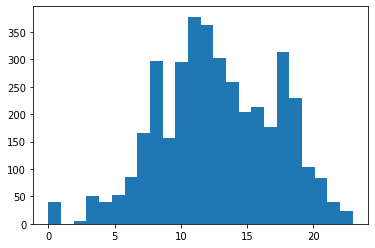

In [55]:
### แสดงการซื้อ (hitAction_type = 6) แจงแจงตามช่วงเวลา

bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([22011., 20836., 17807., 16511., 17866., 23204., 28773., 34309.,
        41773., 45066., 55886., 59403., 49586., 53460., 50273., 40598.,
        41683., 36184., 36316., 31854., 36670., 31523., 32674., 29637.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

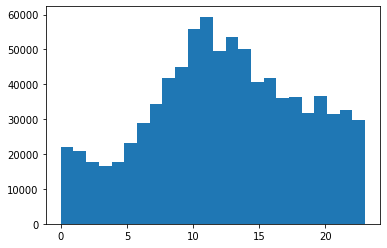

In [56]:
### แสดงการไม่ซื้อ (hitAction_type = 0) แจงแจงตามช่วงเวลา

bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 0).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

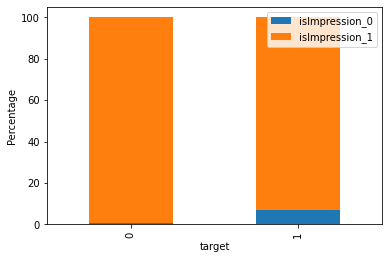

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'isImpression'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()

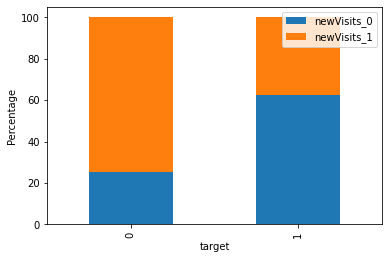

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'newVisits'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()


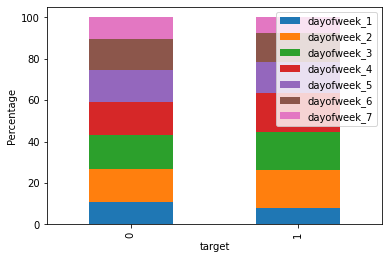

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'dayofweek'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()


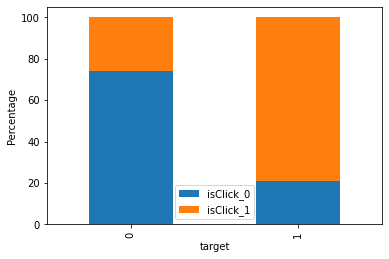

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
x_var = 'target'
groupby_var = 'isClick'

# Group the data by target variable and count the values of dayofweek variable
grouped = df.groupby(x_var)[groupby_var].value_counts()

# Calculate the percentage for each group
grouped_pct = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Create 100% stacked bar chart
fig, ax = plt.subplots()
grouped_pct.unstack().plot(kind='bar', stacked=True, ax=ax)

# Adjust x and y labels
ax.set_xlabel(x_var)
ax.set_ylabel('Percentage')

# Name each part of the stack bar
legend_labels = [f'{groupby_var}_{label}' for label in grouped_pct.unstack().columns]
ax.legend(legend_labels)

# Display the plot
plt.show()


In [61]:
def plot_outliers_and_distribution(df, var, target='target'):
    """
    This function plots a boxplot to check outliers and a violin plot to see the distribution
    grouped by the target variable in one figure.
    df: pandas DataFrame
    var: str, variable/column to check
    target: str, target variable
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

    # Boxplot for outliers
    sns.boxplot(x=target, y=var, data=df, ax=axs[0])
    axs[0].set_title(f'Boxplot of {var} Grouped by {target}')

    # Violin plot for distribution
    sns.violinplot(x=target, y=var, data=df, ax=axs[1])
    axs[1].set_title(f'Violin plot of {var} Grouped by {target}')

    plt.tight_layout()
    plt.show()

# To use the function, simply call it with your DataFrame and variable:
# plot_outliers_and_distribution(df, 'timeOnSite')


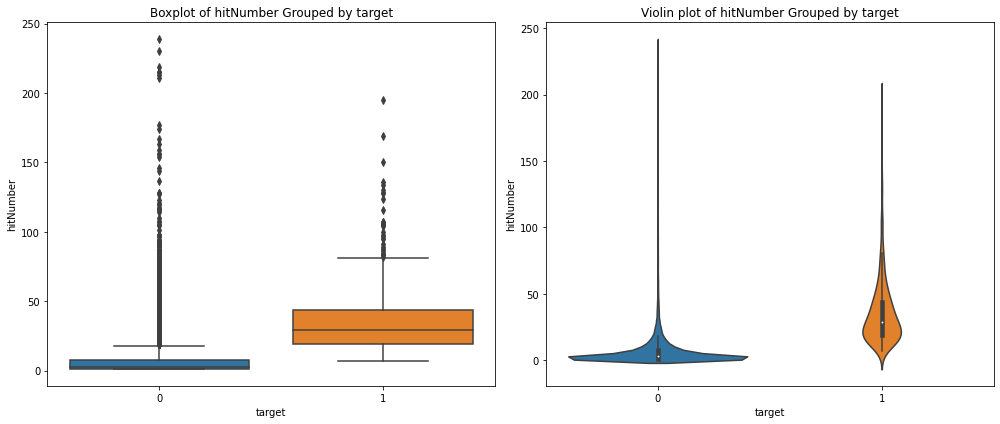

In [62]:
plot_outliers_and_distribution(df, 'hitNumber')

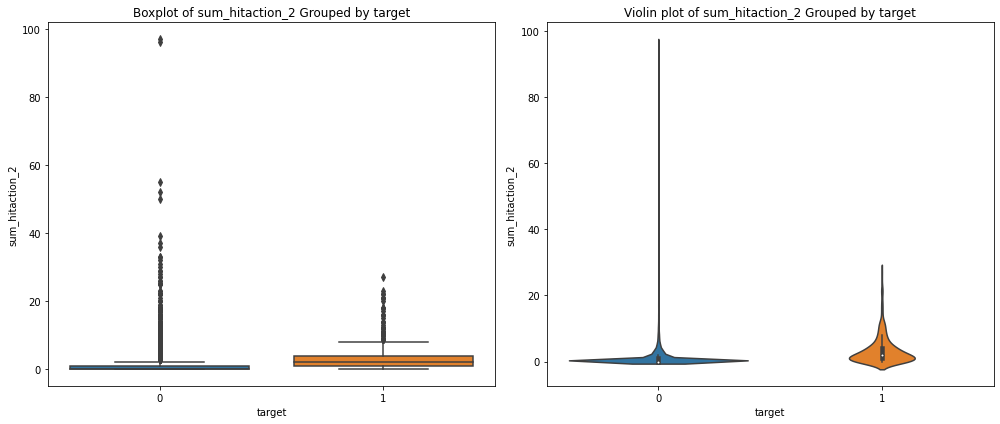

In [63]:
plot_outliers_and_distribution(df, 'sum_hitaction_2')

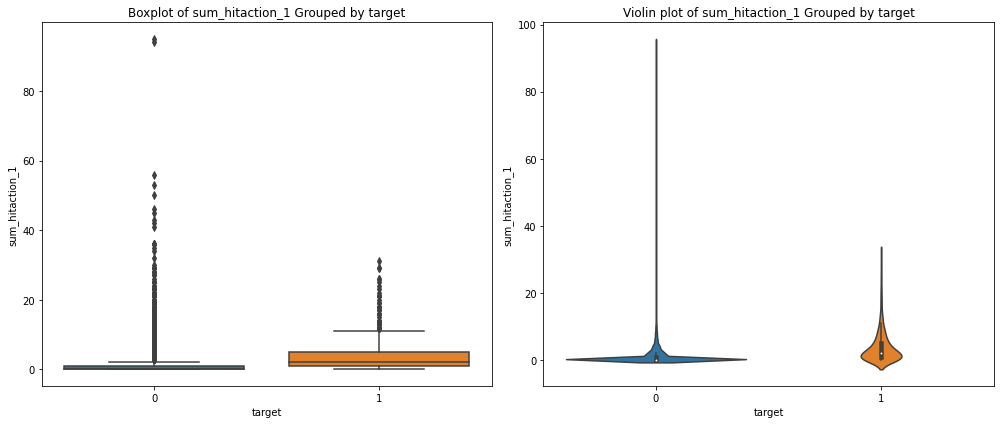

In [64]:
plot_outliers_and_distribution(df, 'sum_hitaction_1')

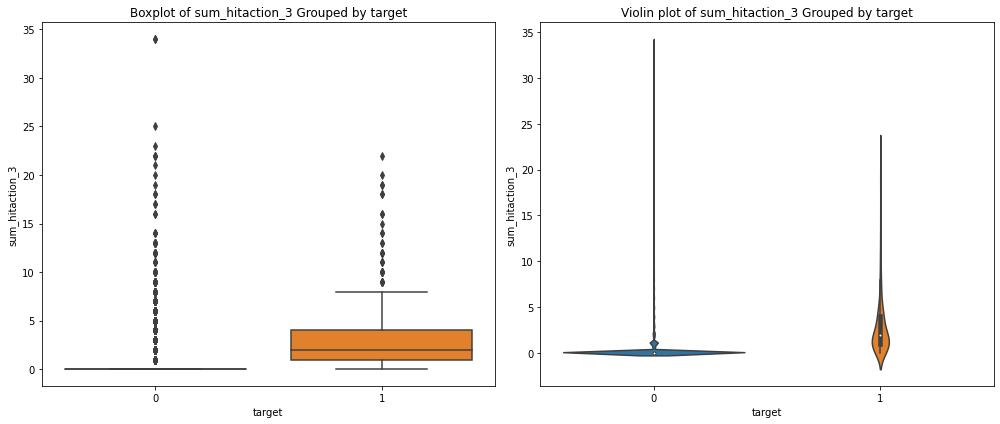

In [65]:
plot_outliers_and_distribution(df, 'sum_hitaction_3')

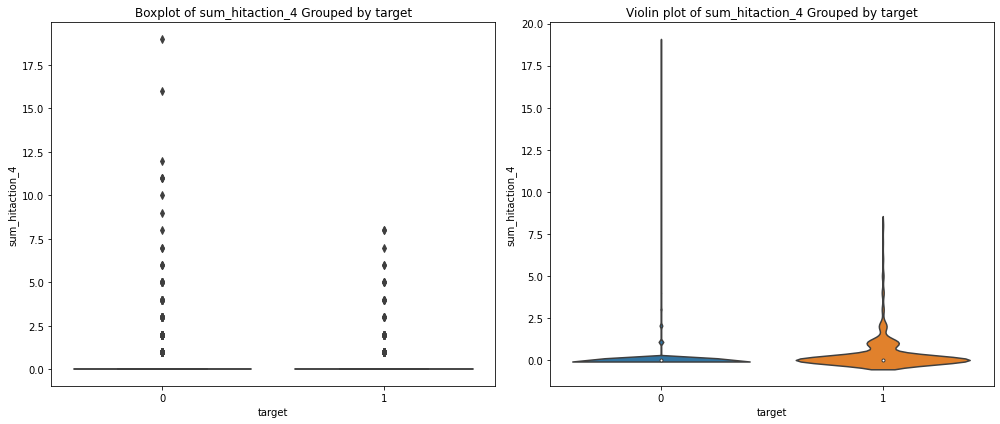

In [66]:
plot_outliers_and_distribution(df, 'sum_hitaction_4')

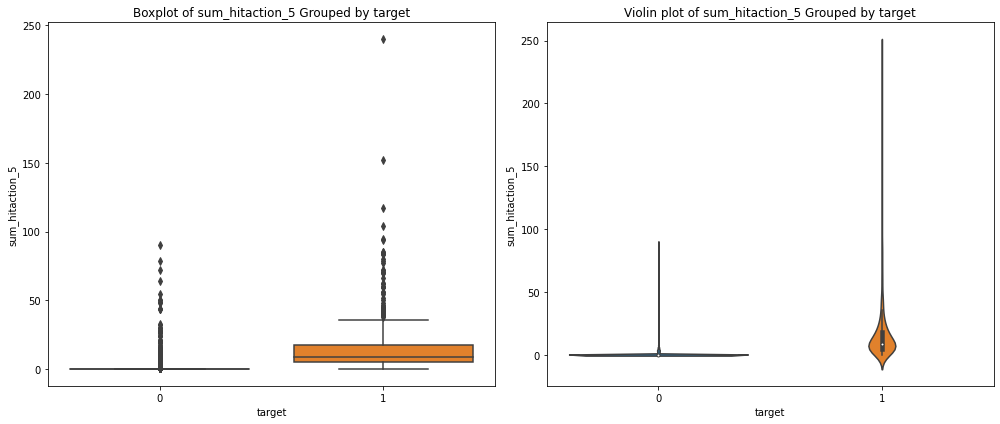

In [67]:
plot_outliers_and_distribution(df, 'sum_hitaction_5')

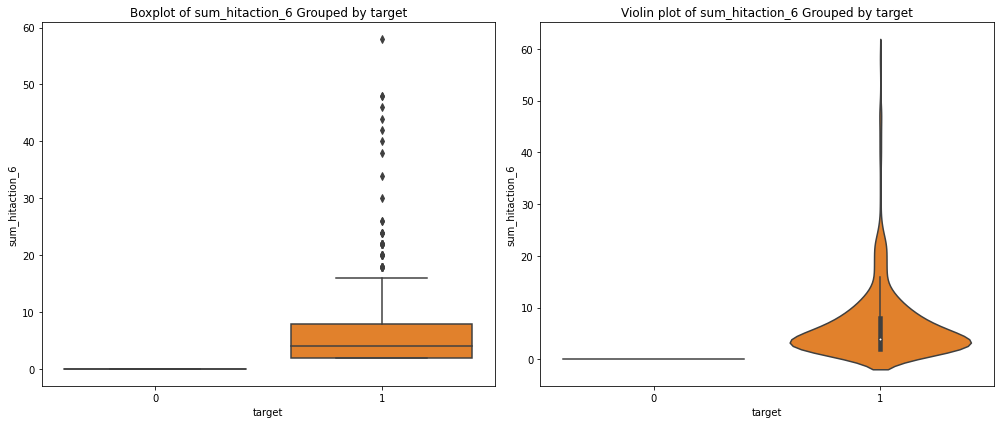

In [68]:
plot_outliers_and_distribution(df, 'sum_hitaction_6')

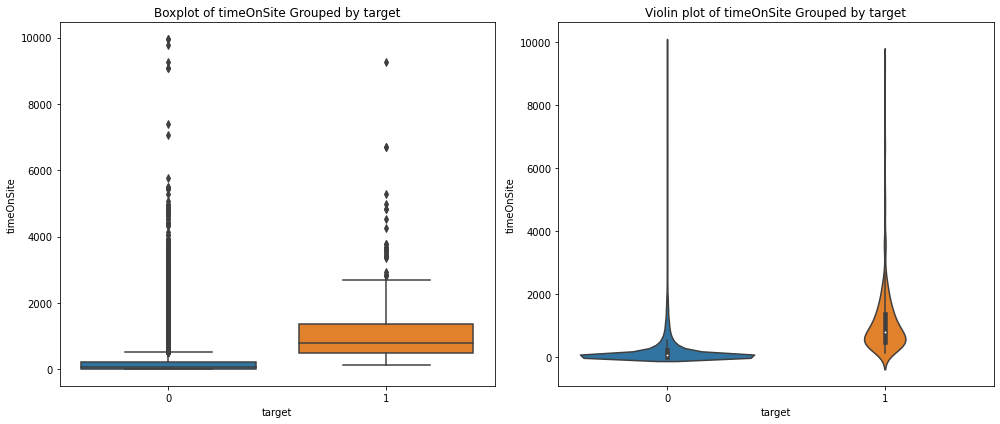

In [69]:
plot_outliers_and_distribution(df, 'timeOnSite')

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_with_hue(dataframe, x_var, y_var, hue_var):
    # Create a new figure and set the size
    plt.figure(figsize=(10, 6))

    # Create a scatter plot with x_var on the x-axis, and y_var on the y-axis
    # Use different colors for different hue_var categories
    sns.scatterplot(x=x_var, y=y_var, hue=hue_var, data=dataframe)

    # Add labels to the x and y axes, and a title to the plot
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title('Scatter Plot of {} vs. {}, by {}'.format(x_var, y_var, hue_var))

    # Display the plot
    plt.show()


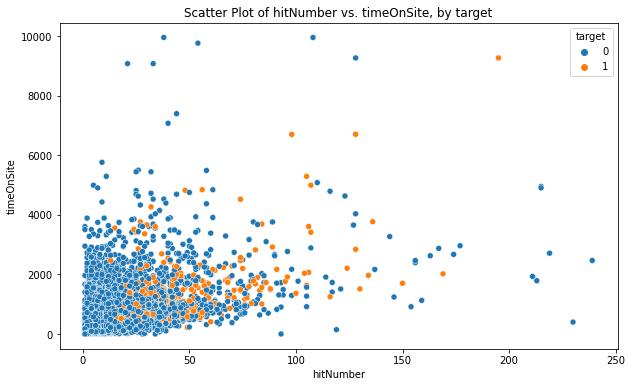

In [71]:
scatter_plot_with_hue(df, 'hitNumber', 'timeOnSite', 'target')


In [72]:
featureTrainingCols = ['isImpression','hitNumber','sum_hitaction_1','sum_hitaction_2','sum_hitaction_5','timeOnSite']

### 4.2 สร้าง Vector ของข้อมูล

In [73]:
label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')

In [74]:
featureTrainingCols.remove('sum_hitaction_5')

In [75]:
vector_assembler = VectorAssembler\
(inputCols = featureTrainingCols, outputCol = 'features')

In [76]:
# pipeline = Pipeline(stages=[productList_indexer, productList_ohe, onehot_encoder, label_stringIdx, vector_assembler])
pipeline = Pipeline(stages=[label_stringIdx, vector_assembler])


In [77]:
final_df = pipeline.fit(noSpurious_df).transform(noSpurious_df)
final_df.sample(0.0001).toPandas().transpose()

,0
fullVisitorId,533460810760360795
visitId,1500505770
dayofweek,4
newVisits,1
hitHour_00_02,0
hitHour_03_05,0
hitHour_06_08,0
hitHour_09_11,0
hitHour_12_14,0
hitHour_15_17,1


In [78]:
raw_df.count() ##Aekanun

917814

In [79]:
noSpurious_df.count() ##Aekanun

23319

### 4.3 แบ่งแยกข้อมูลเป็น training set และ testing set

In [80]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=49)
print("Training Dataset: " + str(train_df.count()))
print("Test Dataset: " + str(test_df.count()))

Training Dataset: 18582


Test Dataset: 4737


In [81]:
train_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|18125|
|  1.0|  457|
+-----+-----+



In [82]:
test_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 4621|
|  1.0|  116|
+-----+-----+



### 4.4 แก้ไข Imbalance class ด้วยการ Oversampling

In [83]:
balanceRatio = train_df.filter(sparkf.col('label') == 1).count() / train_df.count()

In [84]:
balanceRatio

0.02459369282100958

In [85]:
calWeight = sparkf.udf(lambda x: 1 * balanceRatio if x == 0 else (1 * (1.0 - balanceRatio)), DoubleType())

In [86]:
weighted_df = train_df.withColumn('class_weight', calWeight('label'))

In [87]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', weightCol='class_weight', seed=49)

In [88]:
rfModel = rf.fit(weighted_df)

In [89]:
result_df = rfModel.transform(test_df.dropna())

In [90]:
result_df.select(['label', 'prediction']).filter(result_df.label == 1).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [104]:
result_df.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|  116|
|     0| 4621|
+------+-----+



In [92]:
result_df.groupBy('target','label','prediction').count().show()

+------+-----+----------+-----+
|target|label|prediction|count|
+------+-----+----------+-----+
|     1|  1.0|       0.0|    1|
|     0|  0.0|       1.0|  511|
|     1|  1.0|       1.0|  115|
|     0|  0.0|       0.0| 4110|
+------+-----+----------+-----+



In [93]:
featureImportances = rfModel.featureImportances.toArray()

In [94]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [95]:
ExtractFeatureImp(featureImportances, result_df, "features").head(30)

,idx,name,score
1,1,hitNumber,0.667197
4,4,timeOnSite,0.234558
3,3,sum_hitaction_2,0.065977
2,2,sum_hitaction_1,0.032268
0,0,isImpression,0.000000


In [96]:
rfModel.getNumTrees

20

# 5. Evaluation

In [97]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_df))

Area Under ROC = 0.940399


In [98]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')
print('F1 score = %g' % evaluator.evaluate(result_df))
print('Precision = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'precisionByLabel'}))
print('Recall = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'recallByLabel'}))

F1 score = 0.925904


Precision = 0.999757


Recall = 0.889418


## Tuning

In [99]:
paramGrid = ParamGridBuilder() \
.addGrid(rf.numTrees, [20, 50, 100]) \
.build()

In [100]:
crossval = CrossValidator(estimator=rf, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=BinaryClassificationEvaluator(), 
                          numFolds=5)

In [101]:
cvModel = crossval.fit(weighted_df)

In [102]:
result_cv_df = cvModel.transform(test_df.dropna())

In [103]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_cv_df))

Area Under ROC = 0.938343


# 6. Deployment

REST API